In [1]:
import os
print("os")
import glob
print("glob")
import torch
print("torch")
from torch import nn
print("nn")
import torch.nn.functional as F
print("F")
import torch.optim as optim
print("optim")
from torch.utils.data import Dataset
print("Dataset")
from torch.utils.data import DataLoader
print("DataLoader")
from ast import literal_eval
print("literal_eval")
import pandas as pd
print("pd")
import numpy as np
print("np")
import matplotlib.pyplot as plt
print("plt")
import itertools
print("itertools")
import random
print("random")
from torch.autograd import Variable
print("Variable")

os
glob
torch
nn
F
optim
Dataset
DataLoader
literal_eval
pd
np
plt
itertools
random
Variable


In [2]:
torch.cuda.set_device(1) 

In [3]:
class Dataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        # Only select the first 2000 rows for now
        self.labels = pd.read_csv(csv_file).iloc[:]
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        feature_path = os.path.join(self.root_dir, self.labels.iloc[idx,0])
        embeddings = torch.load(feature_path)
        features = embeddings[:, :, :768]
        maps = embeddings[:, :, 768:]
        rmsds = [float(label) for label in literal_eval(self.labels.iloc[idx, 1])]
        if self.transform:
            embedding = self.transform(embedding)
        return features, maps, rmsds, feature_path
    
dataset = Dataset(csv_file='/home/vera/projects/masters_project/data/rmsd_dataset.csv',
                                    root_dir='/home/vera/projects/masters_project/data/s-pred_features/')

In [4]:
if False:
    csv_file_df = pd.read_csv('/home/vera/projects/masters_project/data/rmsd_dataset.csv')

    # Test if the labels have the sane length as the embeddings
    for i in range(len(dataset)):
        features, maps, rmsds, feature_path = dataset[i]
        if features.shape[1] != len(rmsds):
            print('ERROR: The embedding and label for "' + feature_path + '" have different lengths!')
            print('Embedding length: ' + str(features.shape[1]))
            print('Label length: ' + str(len(rmsds)))

            csv_file_df.drop(csv_file_df[csv_file_df['Unnamed: 0'] == feature_path.split('/')[-1]].index, inplace=True)

    # Save the new csv file
    csv_file_df.to_csv('/home/vera/projects/masters_project/data/rmsd_dataset.csv', index=False)

print('False')

False


In [5]:
dataset[1]

(tensor([[[-0.0627,  0.4644,  0.3815,  ..., -0.2154, -0.4263, -0.8542],
          [-0.2771, -0.5295,  0.3261,  ..., -0.5385,  0.6916, -0.0551],
          [-0.6896, -0.8251,  0.2244,  ..., -0.6500,  0.4918, -0.6983],
          ...,
          [-0.6249, -1.5928, -0.3101,  ..., -1.4699, -0.1669, -1.6153],
          [-0.9852, -0.8269,  0.4922,  ..., -0.5268,  0.0339, -1.4123],
          [-0.7165, -0.3634,  0.1148,  ..., -0.0383,  0.6593, -0.9017]]],
        device='cuda:0'),
 tensor([[[0.0021, 0.0031, 0.0012,  ..., 0.0023, 0.0022, 0.0028],
          [0.0024, 0.0024, 0.0031,  ..., 0.0026, 0.0026, 0.0028],
          [0.0022, 0.0029, 0.0031,  ..., 0.0027, 0.0028, 0.0029],
          ...,
          [0.0015, 0.0030, 0.0047,  ..., 0.0026, 0.0026, 0.0029],
          [0.0011, 0.0038, 0.0029,  ..., 0.0027, 0.0025, 0.0029],
          [0.0010, 0.0017, 0.0016,  ..., 0.0023, 0.0021, 0.0027]]],
        device='cuda:0'),
 [0.0,
  0.0,
  0.02,
  0.109,
  0.154,
  1.496,
  1.546,
  1.588,
  1.581,
  1.586,
 

In [6]:
# Split dataset into train, validation and test sets
train_size = int(0.8 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])

# Test if the dataset is split correctly
print(len(train_dataset), len(valid_dataset), len(test_dataset))

# Create the dataloaders
batch_size = 1 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Test if the dataloaders are working correctly
for i, (features, maps, rmsds, feature_path) in enumerate(train_loader):
    print(features.shape)
    print(maps.shape)
    print(len(rmsds))
    print(feature_path)
    break


8304 1038 1038
torch.Size([1, 1, 164, 768])
torch.Size([1, 1, 164, 288])
164
('/home/vera/projects/masters_project/data/s-pred_features/embeddings_5cuh_a.pt',)


KeyboardInterrupt: 

In [7]:
batch_size = 4
# Sort the data by length of the embeddings
train_dataset = sorted(train_dataset, key=lambda x: x[0].shape[1], reverse=True)

# Go through the data and create batches of embeddings with the same length
train_batches = []

for i in range(0, len(train_dataset), batch_size):
    batch = train_dataset[i:i+batch_size]
    # Check if all embeddings in the batch have the same length
    if len(set([embedding[0].shape[1] for embedding in batch])) != 1:
        continue
    train_batches.append(batch)
# Shuffle the batches
random.shuffle(train_batches)

# Test if the batches are created correctly
for i, batch in enumerate(train_batches):
    print('Batch ' + str(i))
    for features, maps, rmsds, feature_path in batch:
        print(features.shape)
        print(maps.shape)
        print(len(rmsds))
        print(feature_path)
    break

# Create data loaders for the batches
batch_size = 4
train_loader = DataLoader(train_batches)

# Test if the dataloaders are working correctly
for i, batch in enumerate(train_loader):
    print('Batch ' + str(i))
    for features, maps, rmsds, feature_path in batch:
        print(features.shape)
        print(maps.shape)
        print(len(rmsds))
        print(feature_path)
    break


print(len(train_batches))



KeyboardInterrupt: 

In [8]:
# Create the LSTM model
class lstm_net(nn.Module):

    def __init__(self, input_feature_size=768, hidden_node=256, dropout=0.25, class_num=8):
        super(lstm_net, self).__init__()

        self.linear_proj = nn.Sequential(
            nn.Linear(input_feature_size, input_feature_size // 2),
            nn.InstanceNorm1d(input_feature_size // 2),
            nn.ReLU(),
            nn.Linear(input_feature_size // 2, input_feature_size // 4),
            nn.InstanceNorm1d(input_feature_size // 4),
            nn.ReLU(),
            nn.Linear(input_feature_size // 4, input_feature_size // 4),
        )

        lstm_input_feature_size = input_feature_size // 4 + 144*2

        self.lstm = nn.LSTM(
            input_size=lstm_input_feature_size,
            hidden_size=hidden_node,
            num_layers=2,
            bidirectional=True,
            dropout=dropout,
            batch_first=True,
        )

        self.to_property = nn.Sequential(
            nn.Linear(hidden_node * 2, hidden_node * 2),
            nn.InstanceNorm1d(hidden_node * 2),
            nn.ReLU(),
            nn.Linear(hidden_node * 2, class_num),
        )

    def forward(self, msa_query_embeddings, msa_attention_features):
        msa_query_embeddings = self.linear_proj(msa_query_embeddings)

        lstm_input = torch.cat([msa_query_embeddings, msa_attention_features], dim=2)
        lstm_input = lstm_input.permute((1, 0, 2))

        lstm_output, lstm_hidden = self.lstm(lstm_input)
        lstm_output = lstm_output.permute((1, 0, 2))
        
        label_output = self.to_property(lstm_output)
        #print(lstm_output)
        #print(label_output)

        return label_output



In [140]:
EPOCHS = 10
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0
#WEIGHT_DECAY = 0.0001
BATCH_SIZE = 1
HIDDEN_NODE = 256
DROPOUT = 0
CLASS_NUM = 1
NUM_ACCUMULATION_STEPS = 2

RMSD_THRESHOLD = 1

#train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


model = lstm_net(input_feature_size=768, hidden_node=HIDDEN_NODE, dropout=DROPOUT, class_num=CLASS_NUM)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

train_loss_list = []
valid_loss_list = []

model.train()

for epoch in range(1, EPOCHS+1):
    model.zero_grad()
    train_loss = 0
    valid_loss = 0

    for i, (features, maps, rmsds, feature_path) in enumerate(train_loader):
        features = features[0,:,:,:].to(device)
        maps = maps[0,:,:,:].to(device)
        labels = torch.Tensor([int(label >= RMSD_THRESHOLD) for label in rmsds]).to(device)
        optimizer.zero_grad()

        output = model(msa_query_embeddings=features, msa_attention_features=maps)
        loss = criterion(output[0,:,0], labels)
        loss.backward()
        train_loss += loss.item()
        
        
        optimizer.step()

        

    train_loss_list.append(train_loss / len(train_loader))

    model.eval()
    with torch.no_grad():
        for i, (features, maps, rmsds, feature_path) in enumerate(valid_loader):
            features = features[0,:,:,:].to(device)
            maps = maps[0,:,:,:].to(device)
            labels = torch.Tensor([int(label >= RMSD_THRESHOLD) for label in rmsds]).to(device)

            output = model(msa_query_embeddings=features, msa_attention_features=maps)
            loss = criterion(output[0,:,0], labels)

            valid_loss += loss.item()

        valid_loss_list.append(valid_loss / len(valid_loader))

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss_list[-1], valid_loss_list[-1]))
    
    model.train()
        


TypeError: list indices must be integers or slices, not tuple

In [12]:
csv_file_df = pd.read_csv('/home/vera/projects/masters_project/data/rmsd_dataset.csv')
sequence_length_dict = {}
for i in range(len(csv_file_df)):
    sequence_length = len(literal_eval(csv_file_df.iloc[i,1]))
    if sequence_length not in sequence_length_dict:
        sequence_length_dict[sequence_length] = 1
    else:
        sequence_length_dict[sequence_length] += 1


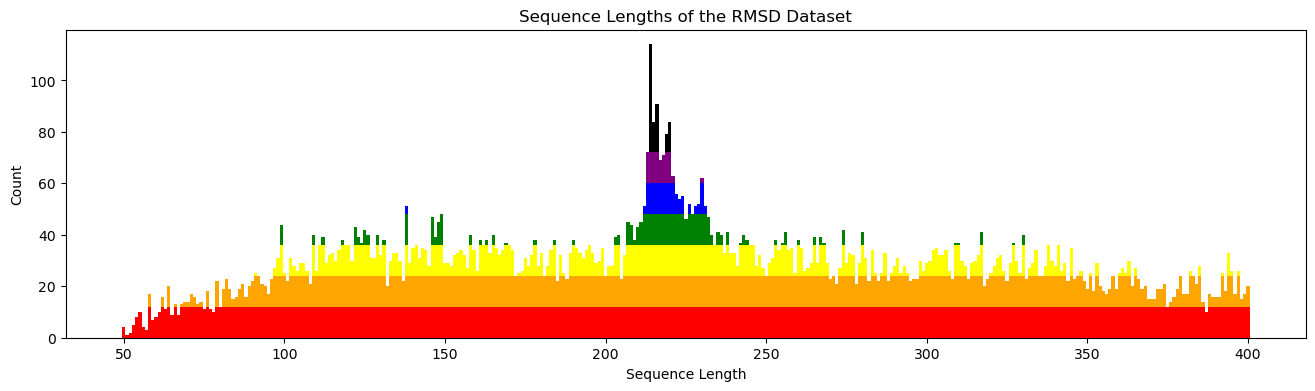

In [39]:
THRESHOLD_1 = 12

# Plot the sequence lengths from the dictionary using a histogram       
plt.figure(figsize=(16,4))
plt.bar(sequence_length_dict.keys(), sequence_length_dict.values(), color='black', width=1)
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']
for i in [6, 5, 4, 3, 2, 1]:
        plt.bar([key for key in sequence_length_dict.keys() if sequence_length_dict[key] < THRESHOLD_1*i],
                [sequence_length_dict[key] for key in sequence_length_dict.keys() if sequence_length_dict[key] < THRESHOLD_1*i],
                color=colors[i-1], width=1)
        plt.bar([key for key in sequence_length_dict.keys() if sequence_length_dict[key] >= THRESHOLD_1*i],
                [THRESHOLD_1*i for key in sequence_length_dict.keys() if sequence_length_dict[key] >= THRESHOLD_1*i],
                color=colors[i-1], width=1)

plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.title('Sequence Lengths of the RMSD Dataset')



plt.show()